Step 100 | Mass remaining: 84.92%
Step 200 | Mass remaining: 63.23%
Step 300 | Mass remaining: 46.50%
Step 400 | Mass remaining: 34.17%
Step 500 | Mass remaining: 25.10%


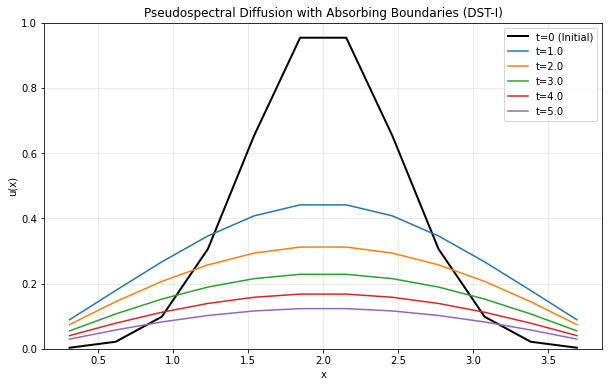

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import dst, idct # idst is used, but idct with types works similarly

# 1. Parameters
L = 4.0            # Domain length
N = 12             # Number of INTERIOR points
alpha = 0.5         # Diffusion coefficient
dt = 0.01           # Time step
steps = 500         # Number of iterations

# 2. Spatial Grid (DST-I uses points strictly INSIDE the boundaries)
# Boundaries are at x=0 and x=10, where u is implicitly 0.
x = np.linspace(0, L, N + 2)[1:-1] 
dx = L / (N + 1)

# 3. Initial Condition: Gaussian pulse in the center
u = np.exp(-(x - L/2)**2 / (2 * 0.5**2))

# 4. Prepare Wavenumbers
# The basis functions are sin(k * pi * x / L)
k = np.arange(1, N + 1)
wavenumbers_sq = (k * np.pi / L)**2

# 5. Time Stepping Loop
plt.figure(figsize=(10, 6))
plt.plot(x, u, label='t=0 (Initial)', color='black', lw=2)

initial_mass = np.sum(u) * dx

for i in range(1, steps + 1):
    # --- Pseudospectral Step ---
    
    # a. Transform to spectral domain (DST-I)
    u_hat = dst(u, type=1)
    
    # b. Apply Diffusion: u_hat_new = u_hat * exp(-alpha * k^2 * dt)
    u_hat_new = u_hat * np.exp(-alpha * wavenumbers_sq * dt)
    
    # c. Transform back (Inverse DST-I)
    # Note: scipy.fft.dst(type=1) is its own inverse (scaled)
    u = dst(u_hat_new, type=1) / (2 * (N + 1))
    
    # 6. Monitor "Absorption" (Mass is NOT conserved)
    if i % 100 == 0:
        current_mass = np.sum(u) * dx
        print(f"Step {i:3d} | Mass remaining: {current_mass/initial_mass:.2%}")
        plt.plot(x, u, label=f't={i*dt:.1f}')

plt.title("Pseudospectral Diffusion with Absorbing Boundaries (DST-I)")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.ylim(0, 1)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Step 100 | Mass remaining: 65.14%
Step 200 | Mass remaining: 36.84%
Step 300 | Mass remaining: 20.74%
Step 400 | Mass remaining: 11.67%
Step 500 | Mass remaining: 6.57%


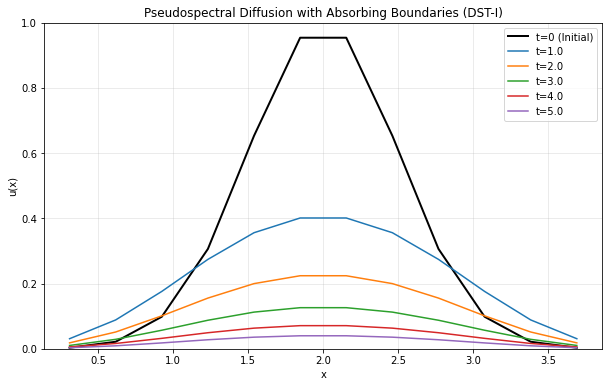

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import dst, idct # idst is used, but idct with types works similarly

# 1. Parameters
L = 4.0            # Domain length
N = 12             # Number of INTERIOR points
alpha = 0.5         # Diffusion coefficient
dt = 0.01           # Time step
steps = 500         # Number of iterations

# 2. Spatial Grid (DST-I uses points strictly INSIDE the boundaries)
# Boundaries are at x=0 and x=10, where u is implicitly 0.
x = np.linspace(0, L, N + 2)[1:-1] 
dx = L / (N + 1)

# 3. Initial Condition: Gaussian pulse in the center
u = np.exp(-(x - L/2)**2 / (2 * 0.5**2))

# 4. Prepare Wavenumbers
# The basis functions are sin(k * pi * x / L)
k = np.arange(1, N + 1)
wavenumbers_sq = (k * np.pi / L)**2

# Conceptual logic for a Sponge Layer:
# Define a damping profile that is 0 in the center and high at the edges
sigma = 10.0 * ((x - L/2) / (L/2))**4  # Damping coefficient

# 5. Time Stepping Loop
plt.figure(figsize=(10, 6))
plt.plot(x, u, label='t=0 (Initial)', color='black', lw=2)

initial_mass = np.sum(u) * dx

for i in range(1, steps + 1):
    # --- Pseudospectral Step ---
    
    # a. Transform to spectral domain (DST-I)
    u_hat = dst(u, type=1)
    
    # b. Apply Diffusion: u_hat_new = u_hat * exp(-alpha * k^2 * dt)
    u_hat_new = u_hat * np.exp(-alpha * wavenumbers_sq * dt)
    
    # c. Transform back (Inverse DST-I)
    # Note: scipy.fft.dst(type=1) is its own inverse (scaled)
    u = dst(u_hat_new, type=1) / (2 * (N + 1))
    
    # Inside the time loop, after the spectral step:
    # This manually "eats" the wave before it hits the symmetry boundary
    u = u * np.exp(-sigma * dt)

    # 6. Monitor "Absorption" (Mass is NOT conserved)
    if i % 100 == 0:
        current_mass = np.sum(u) * dx
        print(f"Step {i:3d} | Mass remaining: {current_mass/initial_mass:.2%}")
        plt.plot(x, u, label=f't={i*dt:.1f}')

plt.title("Pseudospectral Diffusion with Absorbing Boundaries (DST-I)")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.ylim(0, 1)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Step 200 | Mass remaining: 63.71%
Step 400 | Mass remaining: 34.43%
Step 600 | Mass remaining: 18.58%
Step 800 | Mass remaining: 10.03%


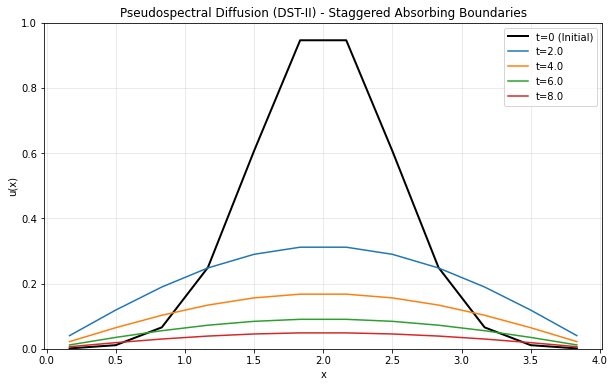

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import dst, idst

# 1. Parameters
L = 4.0            # Domain length
N = 12             # Number of grid points
alpha = 0.5         # Diffusion coefficient
dt = 0.01           # Time step
steps = 800         # Number of iterations

# 2. Staggered Spatial Grid
# Points are at dx/2, 3dx/2, ..., L-dx/2
dx = L / N
x = (np.arange(N) + 0.5) * dx

# 3. Initial Condition: Gaussian pulse in the center
u = np.exp(-(x - L/2)**2 / (2 * 0.5**2))

# 4. Prepare Wavenumbers for DST-II
# For DST-II, the harmonics correspond to k = 1, 2, ..., N
# Scipy's DST-II index 'k' goes from 0 to N-1, representing (k+1)th harmonic
k_indices = np.arange(1, N + 1)
wavenumbers_sq = (k_indices * np.pi / L)**2

# 5. Time Stepping Loop
plt.figure(figsize=(10, 6))
plt.plot(x, u, label='t=0 (Initial)', color='black', lw=2)

initial_mass = np.sum(u) * dx

for i in range(1, steps + 1):
    # --- Pseudospectral Step ---
    
    # a. Transform to spectral domain (DST-II)
    # norm='ortho' ensures the transform is energy-preserving/scaled
    u_hat = dst(u, type=2, norm='ortho')
    
    # b. Apply Diffusion in spectral space
    # u_hat_new = u_hat * exp(-alpha * wavenumber^2 * dt)
    u_hat_new = u_hat * np.exp(-alpha * wavenumbers_sq * dt)
    
    # c. Transform back to spatial domain
    # idst(type=2) is the inverse of dst(type=2)
    u = idst(u_hat_new, type=2, norm='ortho')
    
    # 6. Monitor Absorption
    if i % 200 == 0:
        current_mass = np.sum(u) * dx
        print(f"Step {i:3d} | Mass remaining: {current_mass/initial_mass:.2%}")
        plt.plot(x, u, label=f't={i*dt:.1f}')

plt.title("Pseudospectral Diffusion (DST-II) - Staggered Absorbing Boundaries")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.ylim(0, 1)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Step 200 | Mass remaining: 63.71%
Step 400 | Mass remaining: 34.43%
Step 600 | Mass remaining: 18.58%
Step 800 | Mass remaining: 10.03%


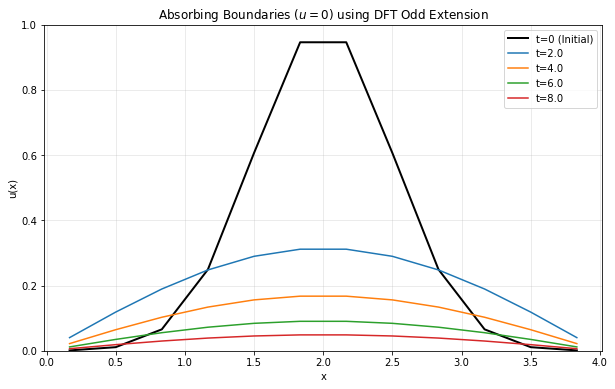

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Parameters
L = 4.0            # Physical domain length
N = 12              # Points in physical domain
alpha = 0.5         # Diffusion coefficient
dt = 0.01           # Time step
steps = 800         # Number of iterations

# 2. Spatial Grid
dx = L / N
x = (np.arange(N) + 0.5) * dx  # Staggered grid (Half-sample)

# 3. Initial Condition: Gaussian pulse
u = np.exp(-(x - L/2)**2 / (2 * 0.5**2))

# 4. Prepare Wavenumbers for the EXTENDED domain (Length 2L, points 2N)
M = 2 * N
L_ext = 2 * L
# k = [0, 1, ..., M/2, -M/2+1, ..., -1] * 2*pi / L_ext
k = np.fft.fftfreq(M, d=(L_ext/M)) * 2 * np.pi
wavenumbers_sq = k**2

# 5. Time Stepping Loop
plt.figure(figsize=(10, 6))
plt.plot(x, u, label='t=0 (Initial)', color='black', lw=2)

initial_mass = np.sum(u) * dx

for i in range(1, steps + 1):
    # --- Pseudospectral DFT Anti-Mirroring Step ---
    
    # a. Create Odd Extension (Absorbing Symmetry)
    # This forces the signal to pass through zero at the boundary x=0 and x=L
    # u_ext looks like: [u0, u1, u2, -u2, -u1, -u0]
    u_ext = np.concatenate([u, -u[::-1]])
    
    # b. Forward FFT
    u_hat = np.fft.fft(u_ext)
    
    # c. Apply Diffusion in Spectral Space
    # Exact solution for u_t = alpha * u_xx: u_hat * exp(-alpha * k^2 * dt)
    u_hat_new = u_hat * np.exp(-alpha * wavenumbers_sq * dt)
    
    # d. Inverse FFT
    u_ext_new = np.real(np.fft.ifft(u_hat_new))
    
    # e. Extract the physical domain (the first half)
    u = u_ext_new[:N]
    
    # 6. Monitor Absorption (Mass is NOT conserved)
    if i % 200 == 0:
        current_mass = np.sum(u) * dx
        print(f"Step {i:3d} | Mass remaining: {current_mass/initial_mass:.2%}")
        plt.plot(x, u, label=f't={i*dt:.1f}')

plt.title("Absorbing Boundaries ($u=0$) using DFT Odd Extension")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.ylim(0, 1)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()